<a href="https://colab.research.google.com/github/SianC7/LAIDS/blob/main/Sian's_1D_CNN_baseline_(%2Bquant).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CICIDS2017 Dataset

In [11]:
import pandas as pd

# --- Data Collection ---

# Set pandas display options for wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Get Data file path
file_path = '/content/drive/MyDrive/Colab Notebooks/Honours Project/Datasets/cicids2017_cleaned.csv'
cicids2017_df = pd.read_csv(file_path, sep=",", comment="#", header=0)
cicids2017_df.columns = cicids2017_df.columns.str.strip()  # Strip whitespace from column names


print("\nInitial samples:")
print(f"cicids2017_df shape: {cicids2017_df.shape}")
print(cicids2017_df.head().to_string())
print(cicids2017_df.info())

# --- Label Encoding ---

cicids2017_df['Attack Type'] = cicids2017_df['Attack Type'].apply(lambda x: 0 if x == 'Normal Traffic' else 1)


Initial samples:
cicids2017_df shape: (2520751, 53)
   Destination Port  Flow Duration  Total Fwd Packets  Total Length of Fwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  Flow Packets/s  Flow IAT Mean   Flow IAT Std  Flow IAT Max  Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  Min Packet Length  Max Packet Length  Packet Length Mean  Packet Length Std  Packet Length Variance  FIN Flag Count  PSH Flag Count  ACK Flag Count  Average Packet Size  Subflow Fwd Bytes  Init_Win_bytes_forward  Init_Win_bytes_backward  act_data_pkt_fwd  min_seg_size_forward  Active Mean  Active Max  Active Min  Idle Mean  Idle Max  Idle Min     Attack Type
0                22     

# Train/val/test split

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Train/val/test split ---
# Split label from datafram
X = cicids2017_df.drop('Attack Type', axis=1)
y = cicids2017_df['Attack Type']

# Split Data
X_temp, X_test, y_temp, y_test= train_test_split(X, y, test_size=0.4, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify = y_temp)

# Shuffle the data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# # --- Label Distribution ---
# print("Training set distribution:")
# print(y_train.value_counts())
# print("\nValidation set distribution:")
# print(y_val.value_counts())
# print("\nTest set distribution:")
# print(y_test.value_counts())

Training set distribution:
Attack Type
0    1005627
1     204333
Name: count, dtype: int64

Validation set distribution:
Attack Type
0    251407
1     51083
Name: count, dtype: int64

Test set distribution:
Attack Type
0    838023
1    170278
Name: count, dtype: int64


Visualisation of data split

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print(f"Input Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Labels[Benign, Mal] -> Train: {np.bincount(y_train)}, Val: {np.bincount(y_val)}, Test: {np.bincount(y_test)}")

train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

# Data for plotting
labels = ['Benign', 'Malicious']
datasets = ['Train', 'Validation', 'Test']
counts = [train_counts, val_counts, test_counts]

# Transpose counts to group by label
benign_counts = [c[0] for c in counts]
mal_counts = [c[1] for c in counts]

x = np.arange(len(datasets))  # the label locations
width = 0.35  # width of the bars

# Plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, benign_counts, width, label='Benign')
rects2 = ax.bar(x + width/2, mal_counts, width, label='Malicious')

# Add labels
ax.set_ylabel('Number of Samples')
ax.set_title('Label Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#Normalise the datasets

In [13]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import numpy as np

# --- Normalize ---
scaler = RobustScaler() # Initialize the scaler

# Apply the scaler
X_train = scaler.fit_transform(X_train) # Standardise data features
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Print the shape of the scaled data to verify
print(f"Shape of X_train after scaling: {X_train.shape}")
print(f"Shape of X_val after scaling: {X_val.shape}")
print(f"Shape of X_test after scaling: {X_test.shape}")

Shape of X_train after scaling: (1209960, 52)
Shape of X_val after scaling: (302490, 52)
Shape of X_test after scaling: (1008301, 52)


# Data reshaping for 1D CNN input

In [14]:
import numpy as np

# Reshape the data for 1D CNN input
# 1D CNN expects input shape: (samples, timesteps, features). timesteps = number of features, features = 1 (per timestep)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# --- Final Shape Confirmation ---
print("Training input shape:", X_train.shape)
print("Validation input shape:", X_val.shape)
print("Test input shape:", X_test.shape)

Training input shape: (1209960, 52, 1)
Validation input shape: (302490, 52, 1)
Test input shape: (1008301, 52, 1)


#1D CNN model

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input

#Step 3: Define the 1D CNN Model

# Input shape
input_shape = (X_train.shape[1], 1)  # input_shape = (time_steps, features) of the training data

# Build model
CNN_model = Sequential([
    Input(shape=input_shape),
    Conv1D(filters=32, kernel_size=3, activation='relu'),   # Detect patterns in the network traffic data
    BatchNormalization(),                                   # Normalizes the outputs of a the Conv1D layer before passing them to the MaxPool layer
    MaxPooling1D(pool_size=2),                              # Reduce the dimensions of the data without affecting key features
    Dropout(0.25),                                          # Prevent overfitting by forcing the model to generalize - it does this by randomly deactivating a fraction of neurons during training

    Conv1D(filters=64, kernel_size=2, activation='relu'),   #kernel_size=3
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),                                                                       # Converts the output of the last Conv1D layer into a 1D vector for the fully connected layers
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), # Apply L2 regularisation to prevent overfitting (common in the dense layer) #https://medium.com/@bhatadithya54764118/day-49-overfitting-and-underfitting-in-dl-regularization-techniques-8ded20baa3d6
    Dropout(0.5),                                                                    # Randomly drop 50% of the network;s neurons to further prevent overfitting
    Dense(1, activation='sigmoid')                                                   # Final output layer( 1 = 1 neuron for binary classification, sigmoid = decides if input is malicious (1) or benign (0))
])

# Compile 1DCNN_model
CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
# 1DCNN_model.summary()

#Train, Evaluate (Test) & Visualize 1D CNN

Epoch 1/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 254s 13ms/step - accuracy: 0.9577 - loss: 0.1986 - val_accuracy: 0.8617 - val_loss: 0.4204
Epoch 2/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 251s 13ms/step - accuracy: 0.9820 - loss: 0.0859 - val_accuracy: 0.8796 - val_loss: 6.2542
Epoch 3/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 263s 13ms/step - accuracy: 0.9828 - loss: 0.0807 - val_accuracy: 0.8767 - val_loss: 0.3905
Epoch 4/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 260s 13ms/step - accuracy: 0.9834 - loss: 0.0777 - val_accuracy: 0.8775 - val_loss: 0.4027
Epoch 5/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 266s 13ms/step - accuracy: 0.9832 - loss: 0.0766 - val_accuracy: 0.8315 - val_loss: 0.5359
Epoch 6/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 257s 13ms/step - accuracy: 0.9843 - loss: 0.0735 - val_accuracy: 0.8803 - val_loss: 0.4018
Epoch 7/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 234s 12ms/step - accuracy: 0.9848 - loss: 0.0732 - val_accuracy: 0.8881 - val_loss: 0.4851
Epoch 8/10
18906/18906 ━━━━━━━━━━━━━━━━━━━━ 267s 13ms/s

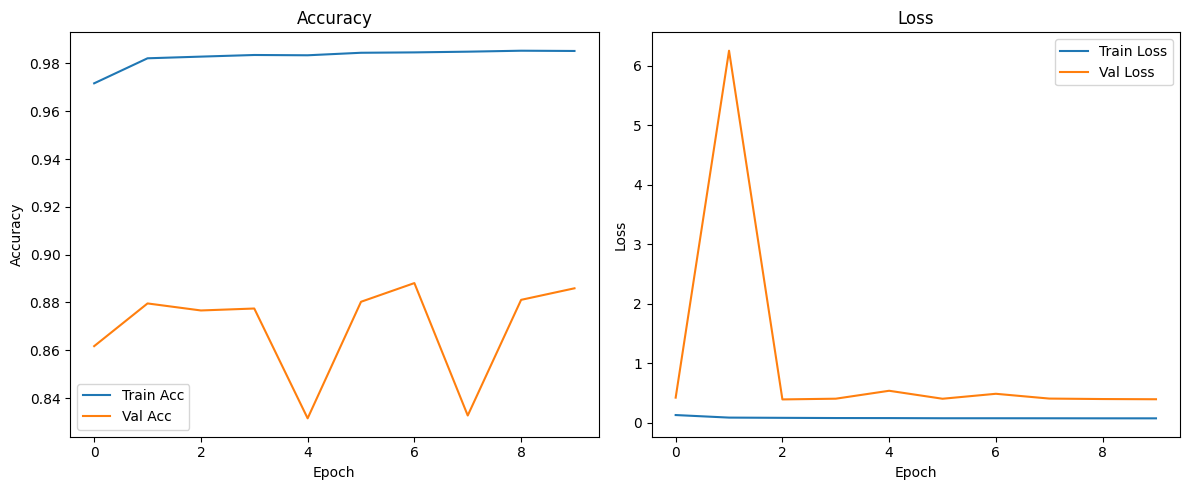

In [16]:
import matplotlib.pyplot as plt
import timeit

# Train the Model
start_time = timeit.default_timer()
history = CNN_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)
end_time = timeit.default_timer()
print(f"Training time: {end_time - start_time:.2f} seconds")

# # Evaluate test set
# test_loss, test_acc = 1DCNN_model.evaluate(X_test, y_test, verbose=0)
# print(f"\nTest Accuracy: {test_acc:.4f}")

# Plot Accuracy and Loss
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Evaluate 1D CNN Malware Detection Results

In [17]:
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# # Get predictions
# y_pred_probs = model.predict(X_test)
# y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to 0 or 1

# # Confusion matrix
# cm = confusion_matrix(y_test, y_pred)

# # Optional: print as table
# print("Confusion Matrix:")
# print(cm)

# # Detailed breakdown
# tn, fp, fn, tp = cm.ravel()
# print(f"\nTrue Negatives (Benign correctly classified): {tn}")
# print(f"False Positives (Benign misclassified as malware): {fp}")
# print(f"False Negatives (Malware missed): {fn}")
# print(f"True Positives (Malware correctly identified): {tp}")

# # Accuracy score
# print("sklearn accuracy:", accuracy_score(y_test, y_pred))

# # Classification report (accuracy, precision, recall, F1)
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Get predictions of x_test dataset
y_pred_probs = CNN_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to 0 or 1, 0.5 = Threshold

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optional: print as table
print("Confusion Matrix:")
print(cm)

# Detailed breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Benign correctly classified): {tn}")
print(f"False Positives (Benign misclassified as malware): {fp}")
print(f"False Negatives (Malware missed): {fn}")
print(f"True Positives (Malware correctly identified): {tp}")

# Accuracy scores
print("Accuracy:")
print("sklearn Accuracy:", accuracy_score(y_test, y_pred))
test_loss, test_acc = CNN_model.evaluate(X_test, y_test, verbose=0)# Evaluate model with test set
print(f"model.evaluate Accuracy: {test_acc:.4f}")
print(f" Confusion Matrix Accuracy: {(tp + tn) / (tp + tn + fp + fn)}")

# Classification report (accuracy, precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malicious"]))

31510/31510 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step
Confusion Matrix:
[[833085   4938]
 [109622  60656]]

True Negatives (Benign correctly classified): 833085
False Positives (Benign misclassified as malware): 4938
False Negatives (Malware missed): 109622
True Positives (Malware correctly identified): 60656
Accuracy:
sklearn Accuracy: 0.8863831336079206
model.evaluate Accuracy: 0.8864
 Confusion Matrix Accuracy: 0.8863831336079206

Classification Report:
              precision    recall  f1-score   support

      Benign       0.88      0.99      0.94    838023
   Malicious       0.92      0.36      0.51    170278

    accuracy                           0.89   1008301
   macro avg       0.90      0.68      0.72   1008301
weighted avg       0.89      0.89      0.86   1008301



# 1D CNN Quant model

In [18]:
import tensorflow as tf
import numpy as np
import os
from sklearn.utils import shuffle

# --- STEP 1: Balance the sample set to 40% benign, 60% malware ---
def balance_sample_data(X_train, y_train, benign_ratio=0.4):
    benign_X = X_train[y_train == 0]
    malware_X = X_train[y_train == 1]

    total = min(len(benign_X) + len(benign_X), 100000)
    benign_n = int(benign_ratio * total)
    malware_n = total - benign_n

    benign_X_sampled = benign_X[np.random.choice(len(benign_X), benign_n)]
    malware_X_sampled = malware_X[np.random.choice(len(malware_X), malware_n)] #ISSUE?

    X_bal = np.vstack((benign_X_sampled, malware_X_sampled))
    y_bal = np.array([0]*benign_n + [1]*malware_n)

    return shuffle(X_bal, y_bal, random_state=42)

# Apply balancing to training data
X_sample, y_sample = balance_sample_data(X_train, y_train, benign_ratio=0.4)

# Ensure 1D shape (samples, timesteps, 1)
X_sample = X_sample.reshape((X_sample.shape[0], X_sample.shape[1], 1))

# --- STEP 2: Define representative dataset for quantization ---
def representative_dataset():
    for i in range(1000):
        index = np.random.randint(0, X_sample.shape[0]) #randomise choices from X_sample data to get a range of diverse samples (not just the first 1000)
        yield [X_sample[index:index+1].astype(np.float32)]

# --- STEP 3: Quantization function ---
def converter_quantization_model(model, model_name):
    os.makedirs('./models', exist_ok=True)

    # Save float32 optimized model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float32]
    converter.representative_dataset = representative_dataset
    tflite_model_float32 = converter.convert()
    with open(model_name + '_quant_float32.tflite', 'wb') as f:
        f.write(tflite_model_float32)

    # Save int8 quantized model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.int8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    converter.representative_dataset = representative_dataset
    tflite_model_int8 = converter.convert()
    with open(model_name + '_quant_int8.tflite', 'wb') as f:
        f.write(tflite_model_int8)

# --- STEP 4: Apply conversion ---
converter_quantization_model(CNN_model, './models/1Dcnn')


Saved artifact at '/tmp/tmp5ppfu04o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 52, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134926203559120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926203556624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926203557200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926203558544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926203554704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926203555664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926203557584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926203559888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926203554128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926203559696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134926203558736: Ten

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


#Evaluate int8 1D CNN

In [19]:
from tensorflow.lite.python.interpreter import Interpreter
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import time


def evaluate_tflite_model(tflite_path, X_test, y_test):
    #Load and Prepare TFLite Interpreter
    interpreter = Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    #Fetch input & output Tensor Details from the TensorFlow Lite Interpreter after the model is loaded and memory for its tensors is allocated.
    input_details = interpreter.get_input_details() #Input tensor: shape, dtype, index.
    output_details = interpreter.get_output_details() #Output tensor: shape, dtype, index, quantisation.

    #Store the tensor indices and data types for input/output
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']
    input_dtype = input_details[0]['dtype']
    output_dtype = output_details[0]['dtype']

    # Calculate Quantization Threshold
    output_scale, output_zero_point = output_details[0]['quantization']#Get quantization parameters for the output
    if output_dtype == np.int8:
        quantized_threshold = int(round(0.5 / output_scale + output_zero_point)) #Computes the int8 value that corresponds to 0.5 — the usual binary classification threshold for float.

    #Initializes empty lists to store predictions and timing
    predictions = []
    processing_times = []

    for i in range(len(X_test)):
        #input_data = np.expand_dims(X_test[i], axis=0).astype(input_dtype)#Prepare Input Tensor and Run Inference
        input_data = np.expand_dims(X_test[i], axis=0)

        if input_dtype == np.int8:
            input_scale, input_zero_point = input_details[0]['quantization']
            input_data = (input_data / input_scale + input_zero_point).astype(np.int8)
        else:
            input_data = input_data.astype(input_dtype)

        start_time = time.time()
        interpreter.set_tensor(input_index, input_data) #Loads input into the interpreter.
        interpreter.invoke() #Execute the model
        output = interpreter.get_tensor(output_index) #Gets the output tensor.
        processing_times.append(time.time() - start_time)

        # Handle prediction thresholding for float and int8 models
        if output_dtype == np.float32:
            pred = (output[0][0] > 0.5).astype(int)
        elif output_dtype == np.int8:
            pred = (output[0][0] > quantized_threshold).astype(int) #If int8, compare against precomputed quantized threshold
        else:
            raise ValueError(f"Unsupported output dtype: {output_dtype}")

        predictions.append(pred)

    #Evaluate Accuracy and Confusion Matrix
    acc = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    print(f"{tflite_path} Accuracy: {acc:.4f}")
    print(f"Avg inference time: {np.mean(processing_times)*1000:.2f} ms/sample")
    print("Confusion Matrix:")
    print(cm)

    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        print(f"\nTrue Negatives (Benign correctly classified): {tn}")
        print(f"False Positives (Benign misclassified as malware): {fp}")
        print(f"False Negatives (Malware missed): {fn}")
        print(f"True Positives (Malware correctly identified): {tp}")
    else:
        print("\nWarning: Confusion matrix is not 2x2 — check labels.")

# Execute evaluation function:
evaluate_tflite_model("./models/1Dcnn_quant_float32.tflite", X_test, y_test)
evaluate_tflite_model("./models/1Dcnn_quant_int8.tflite", X_test, y_test)


./models/1Dcnn_quant_float32.tflite Accuracy: 0.8864
Avg inference time: 0.02 ms/sample
Confusion Matrix:
[[833085   4938]
 [109622  60656]]

True Negatives (Benign correctly classified): 833085
False Positives (Benign misclassified as malware): 4938
False Negatives (Malware missed): 109622
True Positives (Malware correctly identified): 60656
./models/1Dcnn_quant_int8.tflite Accuracy: 0.8312
Avg inference time: 0.02 ms/sample
Confusion Matrix:
[[837897    126]
 [170047    231]]

True Negatives (Benign correctly classified): 837897
False Positives (Benign misclassified as malware): 126
False Negatives (Malware missed): 170047
True Positives (Malware correctly identified): 231
